# Test of bespoke neural network

Import necessary modules:

In [ ]:
from classes.MyModel import MyModel
import torch
import torch.nn as nn
import math as math
from pathlib import Path
from torchviz import make_dot
from time import strftime

from modules.helper_functions_tsp import (find_problem_size,
                                          find_distances_array,
                                          cost_fn_fact, 
                                          cost_fn_tensor, 
                                          hot_start, 
                                          hot_start_list_to_string
                                          )

from modules.config import GRAPH_DIR, VERBOSE
from modules.helper_ML_functions import (find_device, 
                                         get_ready_to_train,
                                         train_model
                                         )

from modules.graph_functions import (plot_sine_activation,
                                     plot_model_training
                                     )

from classes.MyDataLogger import MyDataLogger, MySubDataLogger

Set up constants:

In [2]:
#LOCATIONS = 8                       #locations in problem
#DECODING_FORMULATION = 'original'   #decoding formulation
#                                    #options: 'original', 'new'
#GRAY = False                        #gray code  
#NUM_EPOCHS = 50                     #number of epochs for training
#VERBOSE = False                     #controls how much output the model produces
#SHOTS = 64                          #size of input tensor.  Reduces randomness

In [3]:
datalogger = MyDataLogger()
my_subid = strftime('%H-%M-%S')
sdl = MySubDataLogger(runid = datalogger.runid)
sdl.update_general_constants_from_config()
sdl.update_ml_constants_from_config()
sdl.quantum = False
sdl.validate_input()

SubDataLogger instantiated.  Run ID = 20250401-22-03-56 - 22-03-56


Read in data, report on data read and validate distance array:

In [4]:
#distance_array, best_dist = find_distances_array(LOCATIONS, print_comments=True)
distance_array, best_dist = find_distances_array(sdl.locations, print_comments=True)

Reading distance data
Data will be read from filename networks\five_d.txt.
It is known that the shortest distance is 19


Evaluate cost function and clear cache:

In [ ]:
#cost_fn = cost_fn_fact(LOCATIONS, distance_array, GRAY, method = DECODING_FORMULATION, verbose=VERBOSE)
cost_fn = cost_fn_fact(sdl.locations, 
                       distance_array, 
                       sdl.gray, 
                       method = sdl.formulation, 
                       verbose=VERBOSE
                       )
cost_fn.clear_cache()

Check if CUDA is available and set the device

In [6]:
device = find_device()
print(f"Using device: {device}")

Using device: cuda


Find problem size:

In [7]:
#qubits = find_problem_size(LOCATIONS, DECODING_FORMULATION)
#print(f'There are {qubits} qubits needed for {LOCATIONS} locations in the {DECODING_FORMULATION} formulation.')
qubits = find_problem_size(sdl.locations, sdl.formulation)
print(f'There are {qubits} qubits needed for {sdl.locations} locations in the {sdl.formulation} formulation.')

There are 5 qubits needed for 5 locations in the original formulation.


Find a hot start using a lazy classical algorithm and find the quality of the hot start:

In [8]:
#hot_start_list = hot_start(distance_array, LOCATIONS)
hot_start_list = hot_start(distance_array, sdl.locations)
print(f'The hot start location list is {hot_start_list}')
#bin_hot_start_list = hot_start_list_to_string(hot_start_list, LOCATIONS, GRAY, DECODING_FORMULATION)
bin_hot_start_list = hot_start_list_to_string(hot_start_list, 
                                              sdl.locations, 
                                              sdl.gray, 
                                              sdl.formulation
                                              )
print(f'This is equivalent to a binary list: {bin_hot_start_list}')
bin_hot_start_list_tensor = torch.tensor([bin_hot_start_list])
print(f'bin_hot_start_list_tensor = {bin_hot_start_list_tensor}')
distance_tensor = cost_fn_tensor(bin_hot_start_list_tensor, cost_fn).clone().detach().requires_grad_(True)
print(f'The hot start distance is {float(distance_tensor):.2f}, compared to a best distance of {best_dist:.2f}.')

The hot start location list is [0, 3, 2, 1, 4]
This is equivalent to a binary list: [1, 1, 0, 1, 0]
bin_hot_start_list_tensor = tensor([[1, 1, 0, 1, 0]])
The hot start distance is 21.00, compared to a best distance of 19.00.


Set up input as repeated hot start tensor calculated above:

In [11]:
unrepeated_input = bin_hot_start_list_tensor.float().to(device)
my_input = unrepeated_input.repeat(sdl.shots, 1).requires_grad_(True)

Set up model with gradient required:

In [12]:

#model = MyModel(qubits, NUM_LAYERS, STD_DEV, cost_fn).to(device)
model = MyModel(qubits, 
                sdl.layers, 
                sdl.std_dev, 
                cost_fn
                ).to(device)
for param in model.parameters():
    param.requires_grad = True

Report on model parameters:

In [13]:
total_params = sum(
	param.numel() for param in model.parameters()
)
trainable_params = sum(
	p.numel() for p in model.parameters() if p.requires_grad
)

print(f'There are {total_params} parameters in total, of which {trainable_params} are trainable')

for name, param in model.named_parameters():
    print(f"Parameter {name} requires_grad: {param.requires_grad}")

There are 60 parameters in total, of which 60 are trainable
Parameter fc1.weight requires_grad: True
Parameter fc1.bias requires_grad: True
Parameter fc2.weight requires_grad: True
Parameter fc2.bias requires_grad: True


Test the Sine activation function and print out a graph:

Plot the sine activation function:

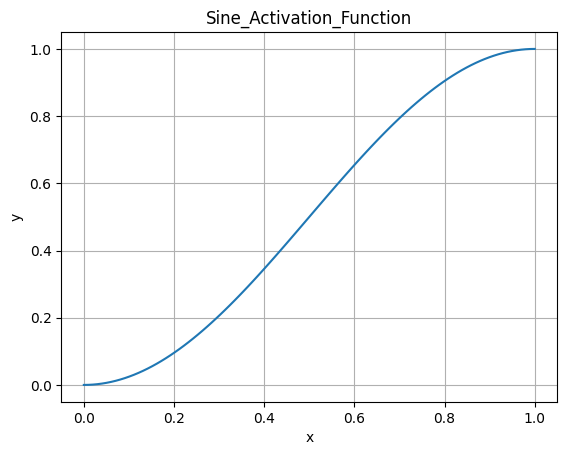

In [14]:
plot_sine_activation()

Print out model details including graph

Output = 23.857421875
{'fc1.weight': Parameter containing:
tensor([[ 0.9908, -0.5668, -0.2436, -0.2767, -1.0370],
        [ 0.2887,  1.5273,  0.3421, -0.0387,  0.1722],
        [-0.6144, -0.5840,  1.2811,  0.3987, -0.7992],
        [-0.2270, -0.0769, -0.3441,  1.0503,  0.2685],
        [-0.1757,  0.6053, -0.4813, -0.2753,  1.8338]], device='cuda:0',
       requires_grad=True), 'fc1.bias': Parameter containing:
tensor([-0.1130, -0.3323,  1.0630,  0.2733,  0.5410], device='cuda:0',
       requires_grad=True), 'fc2.weight': Parameter containing:
tensor([[ 0.9908, -0.5668, -0.2436, -0.2767, -1.0370],
        [ 0.2887,  1.5273,  0.3421, -0.0387,  0.1722],
        [-0.6144, -0.5840,  1.2811,  0.3987, -0.7992],
        [-0.2270, -0.0769, -0.3441,  1.0503,  0.2685],
        [-0.1757,  0.6053, -0.4813, -0.2753,  1.8338]], device='cuda:0',
       requires_grad=True), 'fc2.bias': Parameter containing:
tensor([-0.1130, -0.3323,  1.0630,  0.2733,  0.5410], device='cuda:0',
       requires_grad=True

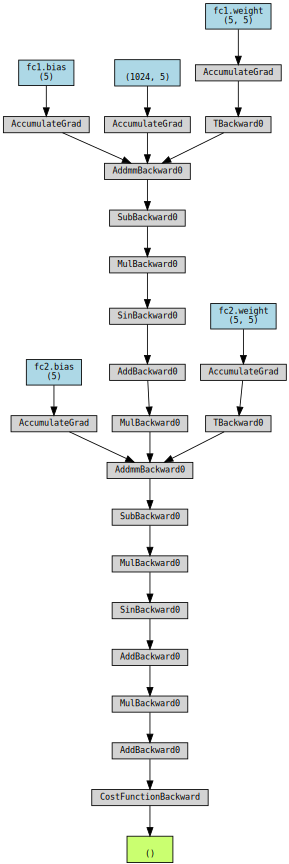

In [15]:
output = model(my_input)
lowest_cost = float(output)
print(f'Output = {output}')
filename = Path(GRAPH_DIR).joinpath('torchviz')

param_dict = dict(model.named_parameters())
print(param_dict)  # Debugging: print the parameters to ensure they seem reasonable
make_dot(output, params=param_dict).render(filename, format="png")
make_dot(output, params=param_dict)

Set up criterion, optimizer and target ready to train model.

In [17]:
#target, criterion, optimizer = get_ready_to_train(model, OPTIMIZER, LR, WEIGHT_DECAY, momentum = MOMENTUM)
target, criterion, optimizer = get_ready_to_train(model, 
                                                  sdl.gradient_type, 
                                                  sdl.lr, 
                                                  sdl.weight_decay, 
                                                  momentum = sdl.momentum
                                                  )

Train model and print out results:

In [18]:
lowest_cost, epoch_lowest_cost, epoch_hist, loss_hist, lowest_history = \
    train_model(sdl.iterations,
                model, 
                my_input, 
                target, 
                criterion,
                optimizer,
                print_results=True
                )

Epoch 0, Cost: 23.871, Lowest Cost to date =  23.871
Epoch 0, fc1.weight grad: 17598.51
Epoch 0, fc1.bias grad: 10160.51
Epoch 0, fc2.weight grad: 10175.83
Epoch 0, fc2.bias grad: 7216.63


In [19]:
print(f'The lowest cost found was {lowest_cost:.3f} at epoch {epoch_lowest_cost}.')
print(f'The best known cost is {best_dist:.3f} and the hot start cost was {float(distance_tensor):.3f}.')

The lowest cost found was 22.203 at epoch 17.
The best known cost is 19.000 and the hot start cost was 21.000.


Plot loss ratio by epoch:

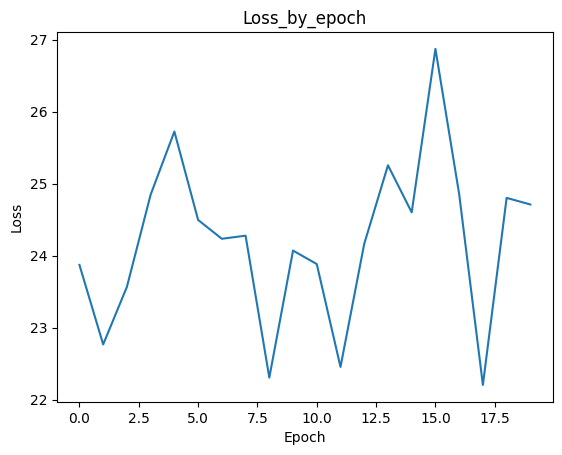

In [ ]:
plot_model_training(epoch_hist, loss_hist)


Print out parameters:

In [21]:
for layer in model.children():
    if isinstance(layer, nn.Linear):
        print('weight:', layer.weight)
        print('bias:', layer.bias)

weight: Parameter containing:
tensor([[ 0.2381, -1.3195, -0.2436, -1.0295, -1.0370],
        [ 1.7578,  2.9965,  0.3421,  1.4305,  0.1722],
        [-0.5631, -0.5327,  1.2811,  0.4500, -0.7992],
        [ 0.5916,  0.7417, -0.3441,  1.8689,  0.2685],
        [-5.1280, -4.3470, -0.4813, -5.2276,  1.8338]], device='cuda:0',
       requires_grad=True)
bias: Parameter containing:
tensor([-0.8658,  1.1368,  1.1143,  1.0919, -4.4112], device='cuda:0',
       requires_grad=True)
weight: Parameter containing:
tensor([[ 0.7107, -0.6577, -0.3145, -0.2328, -1.0044],
        [ 0.0820,  0.6289,  0.8532, -0.4768, -0.1822],
        [ 0.0024, -0.5677,  1.7755,  0.8273, -0.4241],
        [ 0.1418, -0.5969,  0.4395,  0.0903,  0.1713],
        [-0.7272,  0.0104, -0.8411, -0.6107,  1.4854]], device='cuda:0',
       requires_grad=True)
bias: Parameter containing:
tensor([-0.2815, -1.2853,  1.8423,  0.3092, -0.4213], device='cuda:0',
       requires_grad=True)
